# Image Classification using Visual Transformers

## Contents
1. [Overview](#Overview)
2. [Setup](#Setup)
3. [Image pre-processing](#Image-Pre-processing)
4. [Build and Train the Visual Transformer Model](#build-train-model)
5. [Deploy VT-ResNet34 Model to SageMaker Endpoint](#Deploy-VT-ResNet34-Model-to-SageMaker-Endpoint)
6. [References](#References)

Note: 
- Dataset used is **Intel Image Classification** from [Kaggle](https://www.kaggle.com/puneet6060/intel-image-classification).
- The notebook is only an example and not to be used for production deployments.
- Use `Python3 (PyTorch 1.6 Python 3.6 CPU Optimized)` kernel and `ml.m5.large (2 vCPU + 8 GiB)` for the notebook.

## Overview <a name="Overview">

**_Important_** : Notebook has ideas and some of the pseudo code from `Visual Transformers: Token-based Image Representation and Processing for Computer Vision` [research paper](https://arxiv.org/pdf/2006.03677.pdf) but does not reproduce all the results mentioned in the paper. 

In standard image classification algorithms like ResNet, InceptionNet etc., images are represented as pixel arrays on which a series of convolution operations are performed. Although, great accuracy has been achieved with these algorithms, the convolution operation is computationally expensive. Therefore, in this notebook we will look at an alternative way to perform `Image Classification` using the ideas mentioned in the research paper. 

<img src='../img/vt.png' width="600" height="320">

Diagram of a Visual Transformer (VT). For a given image, we first apply convolutional layers to extract low-level
features. The output feature map is then fed to Visual Transformer (VT): First, apply a tokenizer, grouping pixels into a small number of visual tokens. Second, apply transformers to model relation**s**hips between tokens.
Third, visual tokens are directly used for image classification or projected back to the feature map for semantic segmentation.
    

## Setup <a name="Setup">
To start, let's import some Python libraries initialize a SageMaker session, S3 bucket & prefix, and IAM Role.

In [1]:
!pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)


In [2]:
# import python librabries and framework
from pathlib import Path
import numpy as np
import cv2
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from glob import glob
import shutil

import torch, torchvision
from torch import nn, optim
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import sagemaker

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

COLORS_PALETTE=["#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF"]

sns.set_palette(sns.color_palette(COLORS_PALETTE))

rcParams['figure.figsize'] = 15, 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/pytorch-vt-resnet34"
role = sagemaker.get_execution_role()

## Image Pre-processing <a name="Image-Pre-processing">
The dataset used in the notebook is `Intel Image Classification` downloaded from kaggle.com. 
It contains around 25k images of size 150x150 distributed under 6 categories.
```
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }
```
The `train, test and prediction` data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
You can download the dataset from [here](https://www.kaggle.com/puneet6060/intel-image-classification/download), rename the zip file to `data1`, upload it in the Jupyter Lab inside the `image-classification` folder and then follow the steps below. 


In [4]:
# extracting files may take 5-10mins.
from zipfile import ZipFile
with ZipFile('data1.zip', 'r') as zipObj:
   # Extract all the contents of data1.zip file in different data1 directory
   zipObj.extractall('data1')

In [5]:
# Store location for train, test and prediction dataset. 
train_set = './data1/seg_train/seg_train'
test_set = './data1/seg_test/seg_test'
pred_set = './data1/seg_pred/seg_pred'

**We will get each label folder and we can see that we have six folders.** Each of these folders correspond to the classes in the dataset as shown below:

* buildings = 0 
* forest = 1
* glacier = 2
* mountain = 3
* sea = 4
* street = 5 

In [6]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_indices = [0,1,2,3,4,5]

In [7]:
# display the count of folders for each class, since we have 6 classes, lets verify it. 
train_folders = sorted(glob(train_set + '/*'))
len(train_folders)

6

### Defining the helper functions to load and view images.

In [8]:
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    if resize:
        img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
    
    return img

def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')
    
def show_sign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    images = images.permute(0,3,1,2)
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(24,12))
    plt.imshow(grid_img.permute(1,2,0))
    plt.axis('off')

**Display sample images for all 6 classes in the dataset.**

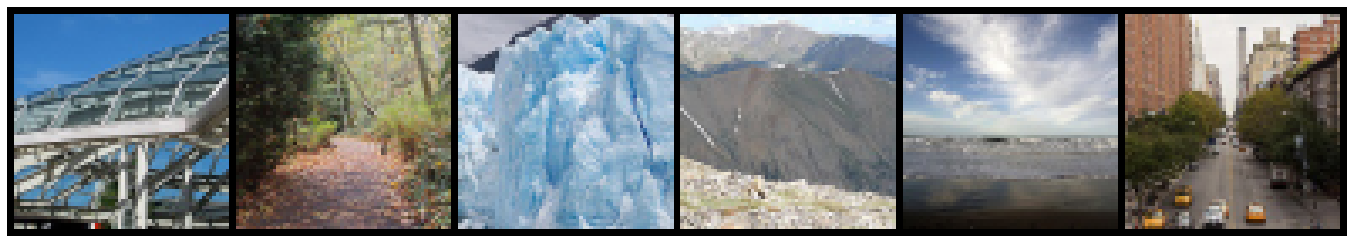

In [9]:
sample_images = [np.random.choice(glob(f'{tf}/*jpg')) for tf in train_folders]
show_sign_grid(sample_images)

**We will copy all the images to new directory to re-organize the structure of the folder, the purpose is to make it easier for `torchvision dataset` helpers to utilize the images.**
The new directory structure will look like this: 
```
|- data
|----train
|----val
```

**We are going to reserve 80% for train and 20% for validation for each class, then copy them to the `data` folder.**

In [10]:
# this step may take 2mins to execute.
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val']

for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [11]:
# counting the images in each class. This may take 1-2mins to execute.
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{train_folders[cls_index]}/*jpg'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)
    
    ds_split = np.split(
        image_paths,
        indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    )
    
    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


**Distribution of classes are good, the total per class ratio is not so high.**

_We add some transformations to artifically increase the size of dataset, particularily random resizing, rotation and horizontal flips, then we normalize the tensors using present values for each channel._

In [12]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size=224),
    T.RandomRotation(degrees=15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
    T.Resize(size=224),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]),}

Lets create the Pytorch Dataloader from the `data` directory.

In [13]:
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=16, shuffle=True, num_workers=4) for d in DATASETS
}

In [14]:
# counting the images in datasets created above.
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
dataset_sizes

{'train': 11224, 'val': 1402}

[2020-12-27 04:57:57.425 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-594def216eaae0b31fbf025840e5:332 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2020-12-27 04:57:57.589 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-594def216eaae0b31fbf025840e5:332 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


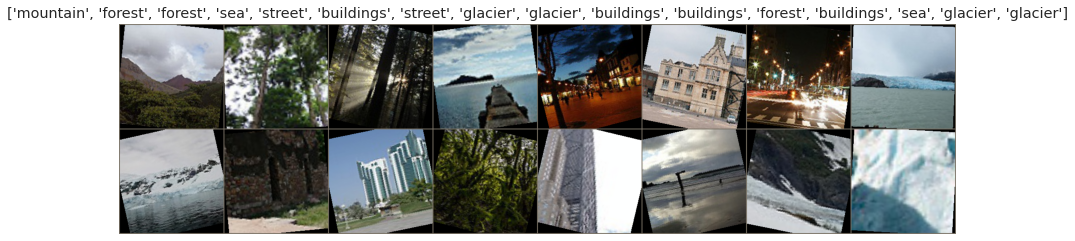

In [15]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Lets have a look at some sample images with all the transformations applied to the images.**

### Uploading the data to S3
We are going to use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value `input_path` identifies the S3 path -- we will use later when we start the training job. This might take few minutes.

In [ ]:
# upload data to S3, this might take few minutes.
input_path = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix=prefix)
print('input specification (in this case, just an S3 path): {}'.format(input_path))

## Build and Train the model <a name="build-train-model">
We will use pretrained resnet34 model and replace the last layer with the custom visual transformer, to classify the images.

1. Create a Visual Transformer class (replacing the last layer with a transformer layer).
2. Import ResNet34 pretrained model.
3. Convert it into training mode.
4. Train the model on new data.
5. Evaluate model performance on `validation loss` , `validation accuracy` and `execution time`. 

All the above steps are performed in `Training script`. 

### Training script
The `vt-resnet-34.py` script provides all the code we need for training and hosting a SageMaker model (`model_fn` function to load a model).
The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

* `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to.
  These artifacts are uploaded to S3 for model hosting.
* `SM_NUM_GPUS`: The number of gpus available in the current container.
* `SM_CURRENT_HOST`: The name of the current container on the container network.
* `SM_HOSTS`: JSON encoded list containing all the hosts .

Supposing one input channel, 'training', was used in the call to the PyTorch estimator's `fit()` method, the following will be set, with the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAINING`: A string representing the path to the directory containing data in the 'training' channel.

For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers).

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to `model_dir` so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an `argparse.ArgumentParser` instance.

Because the SageMaker imports the training script, you should put your training code in a main guard (``if __name__=='__main__':``) if you are using the same script to host your model as we do in this example, so that SageMaker does not inadvertently run your training code at the wrong point in execution.

For example, the script run by this notebook:

In [17]:
!pygmentize code/vt-resnet-34.py

import argparse
import json
import logging
import os
from pathlib import Path
import sys
import torch, torchvision
import torch.distributed as dist
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms
import tokenizerTrans as tokenizer
import projectorTrans as projector
import numpy as np
import pandas as pd
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import time
from PIL import Image
import requests

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

DATASETS = ['train', 'val']

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size=224),
    T.RandomRotation(degrees

## Train on Amazon SageMaker

We use Amazon SageMaker to train and deploy a model using our custom PyTorch code. The Amazon SageMaker Python SDK makes it easier to run a PyTorch script in Amazon SageMaker using its PyTorch estimator. After that, we can use the SageMaker Python SDK to deploy the trained model and run predictions. For more information on how to use this SDK with PyTorch, see [the SageMaker Python SDK documentation](https://sagemaker.readthedocs.io/en/stable/using_pytorch.html).

To start, we use the `PyTorch` estimator class to train our model. When creating our estimator, we make sure to specify a few things:

* `entry_point`: the name of our PyTorch script. It contains our training script, which loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model. It also contains code to load and run the model during inference.
* `source_dir`: the location of our training scripts and requirements.txt file. "requirements.txt" lists packages you want to use with your script.
* `framework_version`: the PyTorch version we want to use

The PyTorch estimator supports multi-machine, distributed PyTorch training. To use this, we just set train_instance_count to be greater than one. Our training script supports distributed training for only GPU instances. 

After creating the estimator, we then call fit(), which launches a training job. We use the Amazon S3 URIs where we uploaded the training data earlier.

In [20]:
from datetime import datetime
from sagemaker.pytorch import PyTorch

now = datetime.now()
timestr = now.strftime("%m-%d-%Y-%H-%M-%S")
vt_training_job_name = "vt-training-{}".format(timestr)
print(vt_training_job_name)

estimator = PyTorch(
    entry_point="vt-resnet-34.py",
    source_dir="code",
    role=role,
    framework_version="1.6.0",
    py_version="py3",
    instance_count=1,  # this script only supports single instance multi-gpu distributed data training.
    instance_type="ml.p3.8xlarge", 
    use_spot_instances=False, # you can set it to True if you want to use Spot instance for training which might take some additional time, but are more cost effective.
#     max_run=3600, # uncomment it, if use_spot_instances = True
#     max_wait=3600, # uncomment it, if use_spot_instances = True
    debugger_hook_config=False,
    hyperparameters={
        "epochs": 5,
        "num_classes": 6,
        "batch-size": 256,
    },
    metric_definitions=[
                   {'Name': 'validation:loss', 'Regex': 'Valid_loss = ([0-9\\.]+);'},
                   {'Name': 'validation:accuracy', 'Regex': 'Valid_accuracy = ([0-9\\.]+);'},
                   {'Name': 'train:accuracy', 'Regex': 'Train_accuracy = ([0-9\\.]+);'},
                   {'Name': 'train:loss', 'Regex': 'Train_loss = ([0-9\\.]+);'},
                ]
)
estimator.fit({"training": input_path}, wait=True, job_name=vt_training_job_name)

vt-training-12-27-2020-05-15-26


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: vt-training-12-27-2020-05-15-26


2020-12-27 05:15:27 Starting - Starting the training job...
2020-12-27 05:15:51 Starting - Launching requested ML instancesProfilerReport-1609046127: InProgress
......
2020-12-27 05:16:51 Starting - Preparing the instances for training......
2020-12-27 05:17:52 Downloading - Downloading input data.........
2020-12-27 05:19:16 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-12-27 05:19:38,300 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2020-12-27 05:19:38,342 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-12-27 05:19:38,350 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-12-27 05:19:38,808 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training"

In [ ]:
vt_training_job_name = estimator.latest_training_job.name
print("Visual Transformer training job name: ", vt_training_job_name)

## Deploy VT-ResNet34 Model to SageMaker Endpoint <a name="Deploy-VT-ResNet34-Model-to-SageMaker-Endpoint">

In [ ]:
from sagemaker import get_execution_role
ENDPOINT_NAME='pytorch-inference-{}'.format(timestr)
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.p3.2xlarge', endpoint_name=ENDPOINT_NAME)

In [ ]:
import json
import requests
from IPython.display import Image 
import json
import boto3
import numpy as np

runtime= boto3.client('runtime.sagemaker')
client = boto3.client('sagemaker')

endpoint_desc = client.describe_endpoint(EndpointName=ENDPOINT_NAME)
print(endpoint_desc)
print('---'*60)

## Making Predictions with VT-ResNet34 Model using SageMaker Endpoint

Inference dataset is taken from `Registry of Open Data from AWS` (https://registry.opendata.aws/multimedia-commons/).

In [ ]:
payload =  '[{"url":"https://multimedia-commons.s3-us-west-2.amazonaws.com/data/images/139/019/1390196df443f2cf614f2255ae75fcf8.jpg"},\
{"url":"https://multimedia-commons.s3-us-west-2.amazonaws.com/data/images/139/015/1390157d4caaf290962de5c5fb4c42.jpg"},\
{"url":"https://multimedia-commons.s3-us-west-2.amazonaws.com/data/images/139/020/1390207be327f4c4df1259c7266473.jpg"},\
{"url":"https://multimedia-commons.s3-us-west-2.amazonaws.com/data/images/139/021/139021f9aed9896831bf88f349fcec.jpg"},\
{"url":"https://multimedia-commons.s3-us-west-2.amazonaws.com/data/images/139/028/139028d865bafa3de66568eeb499f4a6.jpg"},\
{"url":"https://multimedia-commons.s3-us-west-2.amazonaws.com/data/images/139/030/13903090f3c8c7a708ca69c8d5d68b2.jpg"},\
{"url":"https://multimedia-commons.s3-us-west-2.amazonaws.com/data/images/002/010/00201099c5bf0d794c9a951b74390.jpg"},\
{"url":"https://multimedia-commons.s3-us-west-2.amazonaws.com/data/images/139/136/139136bb43e41df8949f873fb44af.jpg"},\
{"url":"https://multimedia-commons.s3-us-west-2.amazonaws.com/data/images/139/145/1391457e4a2e25557cbf956aaee4345.jpg"}]'

payload = json.loads(payload)
for item in payload:
    item = json.dumps(item)
    response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME, 
                                   ContentType='application/json', 
                                   Body=item)
    result = response['Body'].read()
    result = json.loads(result)
    print('predicted:', result[0]['prediction'])

    from PIL import Image
    import requests

    input_data = json.loads(item)
    url = input_data['url']
    im = Image.open(requests.get(url, stream=True).raw)
    newsize = (250, 250) 
    im1 = im.resize(newsize) 

    from IPython.display import Image
    display(im1)

# Cleanup

Lastly, please remember to delete the Amazon SageMaker endpoint to avoid charges. Uncomment following statement `predictor.delete_endpoint()` to do so. 

In [ ]:
predictor.delete_endpoint()

## References <a name="References">
- [1] Visual Transformers: Token-based Image Representation and Processing for Computer Vision (https://arxiv.org/pdf/2006.03677.pdf)
- [2] Kaggle notebook (https://www.kaggle.com/asollie/intel-image-multiclass-pytorch-94-test-acc)
- [3] Registry of Open Data from AWS (https://registry.opendata.aws/multimedia-commons/)